In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [ ]:
# Step 1: Load and Preprocess Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os

# Load dataset
data_path = 'electricity19.csv'
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset file '{data_path}' not found.")

data = pd.read_csv(data_path)

# Display dataset information
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())

# Encode target variable
le = LabelEncoder()
data['stabf'] = le.fit_transform(data['stabf'])

# Split features and target
X = data.drop(columns=['stabf', 'stab'])  # Drop 'stab'
y = data['stabf']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("\nTraining and testing data prepared:")
print(f"Training size: {len(X_train)}, Testing size: {len(X_test)}")


Dataset Head:
       tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3  0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4  3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   

         p4        g1        g2        g3        g4      stab     stabf  
0 -1.723086  0.650456  0.859578  0.887445  0.958034  0.055347  unstable  
1 -1.255012  0.413441  0.862414  0.562139  0.781760 -0.005957    stable  
2 -0.920492  0.163041  0.766689  0.839444  0.109853  0.003471  unstable  
3 -0.997374  0.446209  0.976744  0.929381  0.362718  0.028871  unstable  
4 -0.554305  0.797110  0.455450  0.656947  0.820923  0.049860  unstable  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
D

In [ ]:
# Step 2: Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Function to tune model
def tune_model(model, param_grid, X_train, y_train):
    print(f"Tuning {model.__class__.__name__}...")
    grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                               scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best params for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Hyperparameter tuning
models = {
    "Random Forest": tune_model(RandomForestClassifier(random_state=42),
                                {"n_estimators": [50, 100], "max_depth": [10, None]},
                                X_train, y_train),
    "XGBoost": tune_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                          {"n_estimators": [50, 100], "max_depth": [5, 10]},
                          X_train, y_train),
    "CatBoost": tune_model(CatBoostClassifier(verbose=0, random_state=42),
                           {"iterations": [50, 100], "depth": [6, 10]},
                           X_train, y_train),
    "LightGBM": tune_model(LGBMClassifier(random_state=42),
                           {"n_estimators": [50, 100], "num_leaves": [31, 50]},
                           X_train, y_train)
}


Tuning RandomForestClassifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params for RandomForestClassifier: {'max_depth': None, 'n_estimators': 100}
Tuning XGBClassifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[19:44:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Best params for XGBClassifier: {'max_depth': 5, 'n_estimators': 100}
Tuning CatBoostClassifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params for CatBoostClassifier: {'depth': 6, 'iterations': 100}
Tuning LGBMClassifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 5073, number of negative: 2927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634125 -> initscore=0.549954
[LightGBM] [Info] Start training from score 0.549954
Best params for LGBMClassifier: {'n_estimators': 100, 'num_leaves': 31}


In [ ]:
# Step 3: Output Prediction Results for One Cross Validation
predictions_df = pd.DataFrame({'Real Values': y_test.values})

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    predictions_df[model_name] = y_pred

print("\nPredictions DataFrame:")
print(predictions_df.head())

# Save the predictions dataframe to CSV
predictions_df.to_csv("predictions_output.csv", index=False)

# Visualize Results
fig = go.Figure()
fig.add_trace(go.Scatter(y=predictions_df['Real Values'], mode='lines', name='Real Values'))
for model_name in models.keys():
    fig.add_trace(go.Scatter(y=predictions_df[model_name], mode='lines', name=f'{model_name} Predictions'))

fig.update_layout(title="Model Predictions vs Real Values",
                  xaxis_title="Observations",
                  yaxis_title="Values")
fig.show()



Predictions DataFrame:
   Real Values  Random Forest  XGBoost  CatBoost  LightGBM
0            1              1        1         1         1
1            1              1        1         1         1
2            1              1        1         1         1
3            0              0        0         0         0
4            0              0        0         0         0


In [ ]:
# Step 4: Output DataFrame with Accuracy for Training and Test Sets
def evaluate_accuracy(models, X_train, X_test, y_train, y_test):
    accuracy_results = []
    for model_name, model in models.items():
        # Training Accuracy
        train_pred = model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)

        # Testing Accuracy
        test_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)

        accuracy_results.append([model_name, train_acc, test_acc])

    return pd.DataFrame(accuracy_results, columns=['Model', 'Training Accuracy', 'Testing Accuracy'])

accuracy_df = evaluate_accuracy(models, X_train, X_test, y_train, y_test)
print("\nAccuracy Results (Training vs. Testing):")
print(accuracy_df)

# Save accuracy results to CSV
accuracy_df.to_csv("accuracy_results.csv", index=False)

# Visualize Model Performance
fig = go.Figure()
fig.add_trace(go.Bar(x=results_df['Model'], y=results_df['Accuracy'], name='Accuracy'))
fig.add_trace(go.Bar(x=results_df['Model'], y=results_df['Precision'], name='Precision'))
fig.add_trace(go.Bar(x=results_df['Model'], y=results_df['Recall'], name='Recall'))
fig.add_trace(go.Bar(x=results_df['Model'], y=results_df['F1 Score'], name='F1 Score'))

fig.update_layout(
    title="Classification Model Performance",
    xaxis_title="Model",
    yaxis_title="Score",
    barmode='group'
)
fig.show()



Accuracy Results (Training vs. Testing):
           Model  Training Accuracy  Testing Accuracy
0  Random Forest             1.0000             0.914
1        XGBoost             1.0000             0.936
2       CatBoost             0.9825             0.940
3       LightGBM             0.9980             0.941



Confusion Matrix for Random Forest:


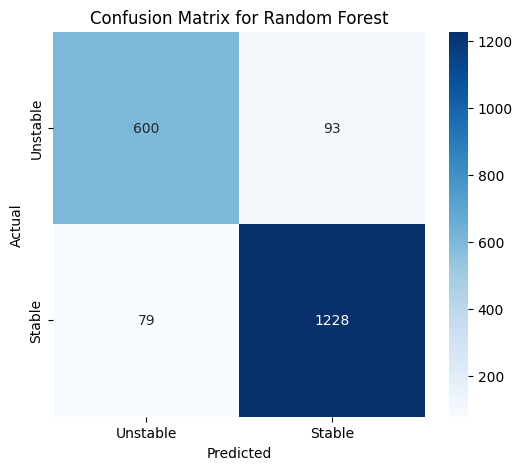


Confusion Matrix for XGBoost:


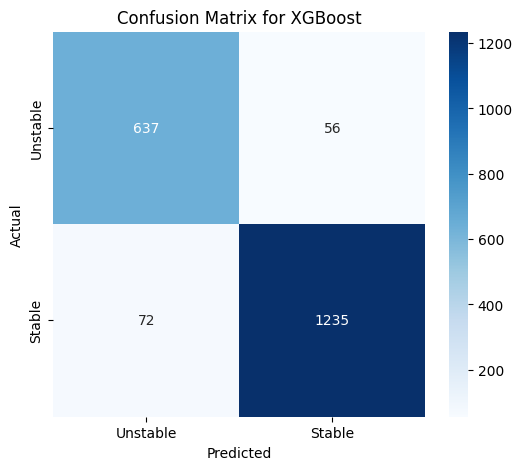


Confusion Matrix for CatBoost:


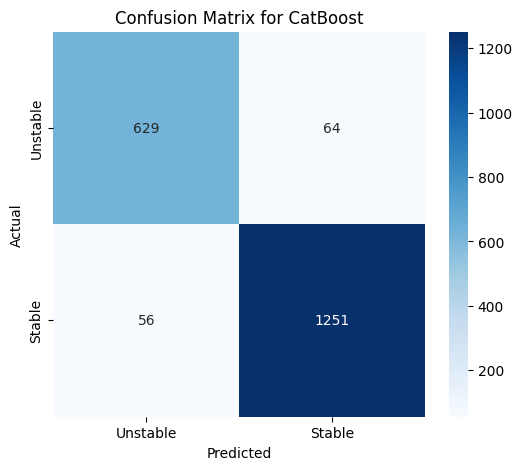


Confusion Matrix for LightGBM:


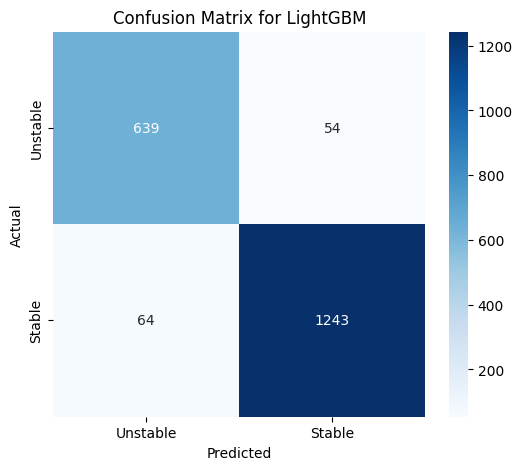

In [ ]:
# Step 6: Output Confusion Matrices
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unstable', 'Stable'], yticklabels=['Unstable', 'Stable'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nConfusion Matrix for {model_name}:")
    plot_confusion_matrix(y_test, y_pred, model_name)


In [ ]:
# Step 7: Select Top 3 Models Based on Accuracy
top_3_models = results_df.nlargest(3, 'Accuracy')

print("\nTop 3 Models Based on Accuracy:")
print(top_3_models)

# Plot Accuracy for Top 3 Models
fig_top3 = go.Figure()
fig_top3.add_trace(go.Bar(
    x=top_3_models['Model'],
    y=top_3_models['Accuracy'],
    name='Accuracy'
))

fig_top3.update_layout(
    title="Top 3 Models Based on Accuracy",
    xaxis_title="Model",
    yaxis_title="Accuracy",
    barmode='group'
)
fig_top3.show()



Top 3 Models Based on Accuracy:
      Model  Accuracy  Precision    Recall  F1 Score
3  LightGBM     0.941   0.958365  0.951033  0.954685
2  CatBoost     0.940   0.951331  0.957154  0.954233
1   XGBoost     0.936   0.956623  0.944912  0.950731
